# ALERT Doctoral School 2023
## Hands-on Deep Q-Network for the Miner game
### Authors: Alexandros Stathas, Diego Gutierrez-Oribio, Ioannis Stefanou

In this code, you can train a Deep Q-Network to solve the Miner game on a 4x4 grid.

#### Main Libraries

In [2]:
from Miner_v1 import Miner
from plotter import plot_env, plot_arrows 
import matplotlib.pyplot as plt
import numpy as np
import gym
import tensorflow as tf
np.set_printoptions(precision=3)

2023-09-18 15:36:44.670817: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-18 15:36:44.672107: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-18 15:36:44.701947: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-18 15:36:44.702483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 15:36:45.174520: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

#### Initialization of the Miner environment

In [3]:
env = Miner(desc=["FFFG", "FFFF", "FFFF", "HSFF"], is_slippery=False, render_mode="ansi")
env.reset()

num_states = env.observation_space.n
num_actions = env.action_space.n

#### Neural network

In [4]:
class DQN(tf.keras.Model):
    def __init__(self, num_actions,input_shape):
        super(DQN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation='relu',input_shape=input_shape)
        self.dense2 = tf.keras.layers.Dense(16, activation='relu')
        self.output_layer = tf.keras.layers.Dense(num_actions, activation='linear')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.output_layer(x)

#### Epsilon greedy policy

In [5]:
def epsilon_greedy_policy(state,epsilon=0):
    state=np.array(state,)

    x_coord=np.arange(1).reshape((-1,1))
    y_coord_states=state.reshape((-1,1))

    states=np.concatenate((x_coord,y_coord_states),axis=1)
    
    states_array = np.zeros((1,num_states))

    states_array[states[:,0],states[:,1]]=1
    states_tensor = tf.convert_to_tensor(states_array,dtype='int8')

    if np.random.rand() < epsilon:
        return np.random.randint(0,4)
    else:
        q_values = dqn_model(states_tensor)
        action = np.argmax(q_values) 
    return action

In [6]:
from collections import deque
replay_buffer = deque(maxlen=2000)

#### Get experiences and play one step

In [7]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer),size = batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [8]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)[:4]
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

#### Training step

In [9]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences

    x_coord=np.arange(batch_size).reshape((-1,1))
    y_coord_states=states.reshape((-1,1))
    states=np.concatenate((x_coord,y_coord_states),axis=1)
    
    states_array = np.zeros((batch_size,num_states))

    states_array[states[:,0],states[:,1]]=1
    states = tf.convert_to_tensor(states_array,dtype='int8') 

    y_coord_next_states=next_states.reshape((-1,1))
    next_states=np.concatenate((x_coord,y_coord_next_states),axis=1)
    
    next_states_array = np.zeros((batch_size,num_states))

    next_states_array[next_states[:,0],next_states[:,1]]=1
    next_states = tf.convert_to_tensor(next_states_array,dtype='int8') 
    
    next_Q_values = dqn_model.predict(next_states)
    max_next_Q_values  = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards+
                        (1-dones)*discount_factor*max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1,1)
    mask = tf.one_hot(actions, num_actions)
    with tf.GradientTape() as tape:
        all_Q_values = dqn_model(states)
        Q_values = tf.reduce_sum(all_Q_values*mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, dqn_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, dqn_model.trainable_variables))
    return

#### Training hyperparameters 

In [10]:
discount_factor=0.99
learning_rate = 10**(-3)
number_of_episodes=400
number_of_steps=12
epsilon1=0.001

In [11]:
# Generate sample next states
batch_size = 32
input_shape = (num_states,)
next_states = tf.random.normal((batch_size,) + input_shape)

# Predict Q-values for the entire batch of next_states
predicted_q_values = dqn_model.predict(next_states)

print("Shape of predicted Q-values:", predicted_q_values.shape)

NameError: name 'dqn_model' is not defined

#### Deep Q-Network algorithm

In [12]:
tf.keras.backend.clear_session()
dqn_model = DQN(num_actions,input_shape)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.mean_squared_error

Reward_per_episode= []
for episode in range(number_of_episodes):
    obs = env.reset()[0]
    Rewards=[]
    for step in range(number_of_steps):
        epsilon = max(1-((episode)**2)*epsilon1, 0.001)
        obs, reward, done, info = play_one_step(env,obs,epsilon)
        Rewards.append(reward)
        if done:
            break
    
    #print('episode, step', episode, step)
    Rewards.reverse()
    Total_Reward =[Rewards[i]*discount_factor**(i) for i in range(0,step)]
    Reward_per_episode.append(np.sum(Total_Reward))
    if episode > 50:
        training_step(batch_size)
    print('Iteration =',episode+1,'/',number_of_episodes)    

Iteration = 1 / 400
Iteration = 2 / 400
Iteration = 3 / 400
Iteration = 4 / 400
Iteration = 5 / 400
Iteration = 6 / 400
Iteration = 7 / 400
Iteration = 8 / 400
Iteration = 9 / 400
Iteration = 10 / 400
Iteration = 11 / 400
Iteration = 12 / 400
Iteration = 13 / 400
Iteration = 14 / 400
Iteration = 15 / 400
Iteration = 16 / 400
Iteration = 17 / 400
Iteration = 18 / 400
Iteration = 19 / 400
Iteration = 20 / 400
Iteration = 21 / 400
Iteration = 22 / 400
Iteration = 23 / 400
Iteration = 24 / 400
Iteration = 25 / 400
Iteration = 26 / 400
Iteration = 27 / 400
Iteration = 28 / 400
Iteration = 29 / 400
Iteration = 30 / 400
Iteration = 31 / 400
Iteration = 32 / 400
Iteration = 33 / 400
Iteration = 34 / 400
Iteration = 35 / 400
Iteration = 36 / 400
Iteration = 37 / 400
Iteration = 38 / 400
Iteration = 39 / 400
Iteration = 40 / 400
Iteration = 41 / 400
Iteration = 42 / 400
Iteration = 43 / 400
Iteration = 44 / 400
Iteration = 45 / 400
Iteration = 46 / 400
Iteration = 47 / 400
Iteration = 48 / 400
I

#### Results

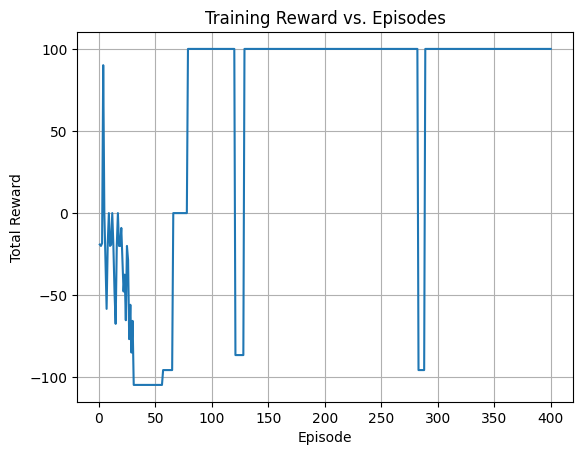

In [13]:
plt.plot(range(1, number_of_episodes + 1), Reward_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Reward vs. Episodes')
plt.grid(True)
plt.show()

In [14]:
next_states = tf.convert_to_tensor(np.identity(16),dtype='int8') 
Q_values= dqn_model.predict(next_states)
print("Final Q-values:\n")
print(Q_values)

1/1 [==============================] - 0s 28ms/step
Final Q-values:

[[ -6.349   3.092  18.951  21.315]
 [ -6.649   1.14   29.51   20.039]
 [ -8.824   1.197  37.197  27.239]
 [ -5.715   3.587  17.862  19.15 ]
 [ -7.625   5.358  21.93   26.04 ]
 [ -7.978   6.855  20.371  29.089]
 [ -6.78    3.067  19.997  22.821]
 [-10.874  11.798  22.344  41.121]
 [ -5.453   1.821  17.101  19.098]
 [ -7.704   8.017  17.194  28.536]
 [ -5.418   4.208  14.782  19.882]
 [-10.048   8.29   22.462  37.834]
 [ -5.584   2.267  18.333  20.098]
 [ -7.437   3.86   20.868  26.861]
 [ -7.02    1.9    25.309  23.46 ]
 [ -7.182   5.229  17.913  27.677]]


Optimal Policy:



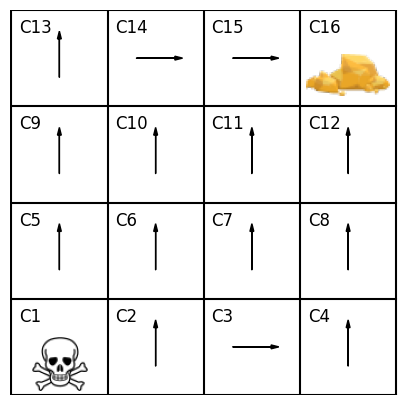

In [15]:
policy = np.argmax(Q_values, axis=1).astype(str)
print("Optimal Policy:\n")
game_actions_to_plotter_arrows = {'0': 2,'1': 1, '3':3, '2':4}
policy_arrow_compatible =np.array([game_actions_to_plotter_arrows[key] for key in np.array(policy,dtype="<U3")],dtype=np.int32)
policy_arrow_compatible=policy_arrow_compatible.reshape((-1,4))[::-1,:].reshape((16))
M=4;Lx=5;Ly=5
fig, ax = plt.subplots()
plot_env(fig,ax,M,Lx,Ly)
plot_arrows(fig,ax,policy_arrow_compatible,M,Lx,Ly)
plt.show()

In [16]:
def Dictionary(s):
    return policy[s]

#### Testing of your policy in the Miner game

In [17]:
# Create the Miner environment with custom map and no slipperiness
env_test = Miner(desc=["FFFG", "FFFF", "FFFF", "HSFF"], is_slippery=False, render_mode="human")
env_test.reset()

# Lists to store states, actions, rewards, and dones during the play
states = np.zeros(6)
states[0] = 13
actions, rewards, dones = [], [], []

def show_state(obs):
    # Render the environment using matplotlib
    env_test.render()
    # Pause for a short time to allow the plot to update
    plt.pause(0.01)

for index in range(5):
    action = Dictionary(int(states[index]))
    obs_tp1, rew, done, _ = env_test.step(int(action))[:4] 

    # Append the states, actions, rewards, and dones to the lists
    states[index+1]=obs_tp1
    actions.append(action)
    rewards.append(rew)
    dones.append(done)  

    # Show the updated state of the environment
    show_state(obs_tp1)

    if done == True:
        if rew > 0:
            print("Congratulations! You reached the gold!")
        else:
            print("Oops! You fell into a hole!")
            
# Print the information after the game ends
print("Total number of moves:", np.size(rewards))
print("Final reward:", int(sum(rewards)))
    
# Close the environment after finishing the game
env_test.close()

Congratulations! You reached the gold!
Total number of moves: 5
Final reward: 100
